### Регрессия для IC50

In [10]:
import numpy as np
import pandas as pd

In [2]:
df_scaled = pd.read_csv('df_scaled.csv')

In [3]:
df_scaled.shape

(969, 188)

In [4]:
df_scaled.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


### Сравнены различные модели с настройкой гиперпараметров, сделаны выводы о применимости методов, даны рекомендации по улучшению.

In [6]:
import joblib
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# Загрузка данных

y = df_scaled['IC50']  # Целевая переменная
X = df_scaled.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Словарь регрессоров для оптимизации
REGRESSORS = {
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'RandomForestRegressor': RandomForestRegressor,
    'CatBoostRegressor': CatBoostRegressor
}

def objective(trial, regressor_name):
    """Оптимизация гиперпараметров."""
    if regressor_name == 'XGBRegressor':
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params)
        
    elif regressor_name == 'DecisionTreeRegressor':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeRegressor(**params)

    elif regressor_name == 'RandomForestRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestRegressor(**params)

    elif regressor_name == 'CatBoostRegressor':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  
        }
        model = CatBoostRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Используем только MSE для оптимизации
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Оптимизация гиперпараметров для каждого регрессора
best_models = {}
for regressor_name in REGRESSORS.keys():
    print(f"Оптимизация гиперпараметров для {regressor_name}...")
    study = optuna.create_study(direction='minimize')  # Минимизируем только MSE
    study.optimize(lambda trial: objective(trial, regressor_name), n_trials=250)

    # Получаем наилучшие параметры и модель
    best_trial = study.best_trial
    best_model = REGRESSORS[regressor_name](**best_trial.params).fit(X_train, y_train)
    best_models[regressor_name] = {
        'best_params': best_trial.params,
        'best_model': best_model,
    }

    print(f"Оптимальные гиперпараметры для {regressor_name}:", best_trial.params)

# Оценка всех моделей на тестовой выборке
for regressor_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"{regressor_name} - Тестовый MSE: {mse}, Тестовый MAE: {mae}, Тестовый R^2: {r2}")


[I 2025-05-23 21:48:14,548] A new study created in memory with name: no-name-face4e21-a01a-433e-a10c-cac17d23113e


Оптимизация гиперпараметров для XGBRegressor...


[I 2025-05-23 21:48:19,666] Trial 0 finished with value: 1.112068056617045 and parameters: {'learning_rate': 0.0019035930616476556, 'max_depth': 14, 'n_estimators': 389, 'subsample': 0.8649427128401499, 'colsample_bytree': 0.6737829045552542}. Best is trial 0 with value: 1.112068056617045.
[I 2025-05-23 21:48:20,211] Trial 1 finished with value: 1.3514198516449587 and parameters: {'learning_rate': 0.12347439681530449, 'max_depth': 3, 'n_estimators': 504, 'subsample': 0.8583182485084961, 'colsample_bytree': 0.8271547654795838}. Best is trial 0 with value: 1.112068056617045.
[I 2025-05-23 21:48:21,008] Trial 2 finished with value: 1.1186338936615923 and parameters: {'learning_rate': 0.004685005218016256, 'max_depth': 8, 'n_estimators': 138, 'subsample': 0.6894842031190621, 'colsample_bytree': 0.6128230861482267}. Best is trial 0 with value: 1.112068056617045.
[I 2025-05-23 21:48:21,392] Trial 3 finished with value: 1.2141649706754347 and parameters: {'learning_rate': 0.000213036138013646

Оптимальные гиперпараметры для XGBRegressor: {'learning_rate': 0.06278463757194659, 'max_depth': 3, 'n_estimators': 70, 'subsample': 0.9611136506470904, 'colsample_bytree': 0.9704093118478327}
Оптимизация гиперпараметров для DecisionTreeRegressor...


[I 2025-05-23 21:50:00,337] Trial 7 finished with value: 1.2026609837976088 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 3 with value: 1.1254721795401268.
[I 2025-05-23 21:50:00,363] Trial 8 finished with value: 1.3472501533919206 and parameters: {'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 3 with value: 1.1254721795401268.
[I 2025-05-23 21:50:00,378] Trial 9 finished with value: 1.155744678653297 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 3 with value: 1.1254721795401268.
[I 2025-05-23 21:50:00,386] Trial 10 finished with value: 1.1744504622526697 and parameters: {'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 1.1254721795401268.
[I 2025-05-23 21:50:00,407] Trial 11 finished with value: 1.1744504622526697 and parameters: {'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 3 wit

Оптимальные гиперпараметры для DecisionTreeRegressor: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 8}
Оптимизация гиперпараметров для RandomForestRegressor...


[I 2025-05-23 21:50:10,530] Trial 0 finished with value: 1.093220175920734 and parameters: {'n_estimators': 201, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 1.093220175920734.
[I 2025-05-23 21:50:13,080] Trial 1 finished with value: 1.1067324410012362 and parameters: {'n_estimators': 515, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 0 with value: 1.093220175920734.
[I 2025-05-23 21:50:16,601] Trial 2 finished with value: 1.0833542383886077 and parameters: {'n_estimators': 319, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 2 with value: 1.0833542383886077.
[I 2025-05-23 21:50:20,831] Trial 3 finished with value: 1.0660504721944748 and parameters: {'n_estimators': 354, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 1.0660504721944748.
[I 2025-05-23 21:50:31,093] Trial 4 finished with value: 1.09669871275945 and parameters: {'n_es

Оптимальные гиперпараметры для RandomForestRegressor: {'n_estimators': 538, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 10}
Оптимизация гиперпараметров для CatBoostRegressor...


[I 2025-05-23 22:17:41,994] Trial 0 finished with value: 1.1415371250323056 and parameters: {'learning_rate': 0.0010141433482929994, 'depth': 9, 'iterations': 383, 'l2_leaf_reg': 0.0013776419668987956}. Best is trial 0 with value: 1.1415371250323056.
[I 2025-05-23 22:17:42,326] Trial 1 finished with value: 1.2141781577685582 and parameters: {'learning_rate': 0.0002636772216772081, 'depth': 2, 'iterations': 345, 'l2_leaf_reg': 0.00032312067488418254}. Best is trial 0 with value: 1.1415371250323056.
[I 2025-05-23 22:17:42,787] Trial 2 finished with value: 1.1852438866142778 and parameters: {'learning_rate': 0.0772272728698854, 'depth': 3, 'iterations': 387, 'l2_leaf_reg': 1.3581108922141512}. Best is trial 0 with value: 1.1415371250323056.
[I 2025-05-23 22:17:43,031] Trial 3 finished with value: 1.1171319345033552 and parameters: {'learning_rate': 0.044252252057605704, 'depth': 1, 'iterations': 377, 'l2_leaf_reg': 0.28919787950959625}. Best is trial 3 with value: 1.1171319345033552.
[I 2

0:	learn: 0.9584591	total: 2.84ms	remaining: 488ms
1:	learn: 0.9559470	total: 5.7ms	remaining: 487ms
2:	learn: 0.9516275	total: 8.24ms	remaining: 467ms
3:	learn: 0.9474050	total: 10.8ms	remaining: 456ms
4:	learn: 0.9431458	total: 13.4ms	remaining: 449ms
5:	learn: 0.9395512	total: 16ms	remaining: 446ms
6:	learn: 0.9365734	total: 18.7ms	remaining: 443ms
7:	learn: 0.9333808	total: 21.2ms	remaining: 438ms
8:	learn: 0.9303685	total: 23.9ms	remaining: 435ms
9:	learn: 0.9268573	total: 26.5ms	remaining: 432ms
10:	learn: 0.9239735	total: 29.2ms	remaining: 430ms
11:	learn: 0.9208020	total: 31.7ms	remaining: 426ms
12:	learn: 0.9183945	total: 34.3ms	remaining: 422ms
13:	learn: 0.9150152	total: 36.8ms	remaining: 418ms
14:	learn: 0.9128493	total: 39.2ms	remaining: 413ms
15:	learn: 0.9104285	total: 41.9ms	remaining: 411ms
16:	learn: 0.9074726	total: 44.4ms	remaining: 408ms
17:	learn: 0.9040115	total: 47.1ms	remaining: 405ms
18:	learn: 0.9001843	total: 49.6ms	remaining: 402ms
19:	learn: 0.8982141	tota

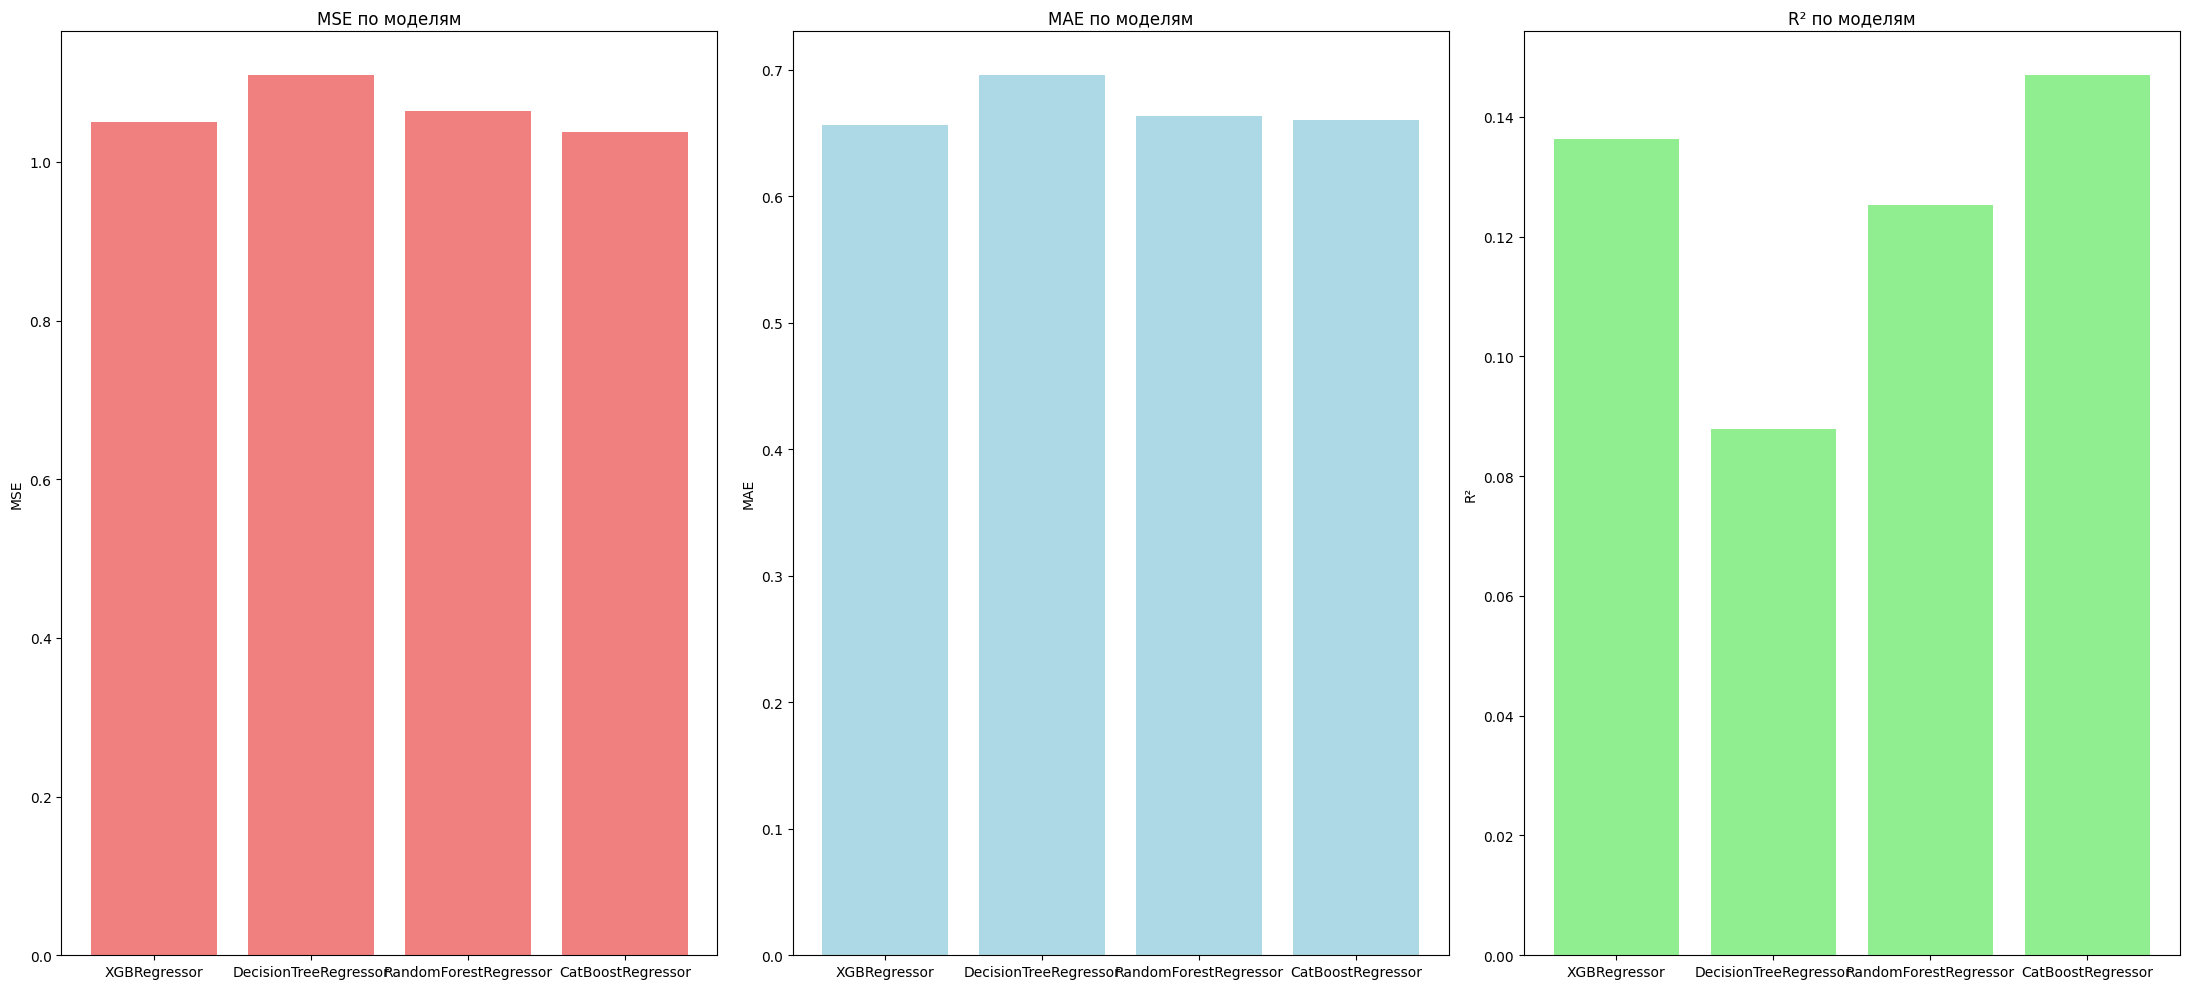

In [9]:
# Визуализация результатов
def plot_results(models_metrics):
    model_names = list(models_metrics.keys())
    mse_values = [metrics[0] for metrics in models_metrics.values()]
    mae_values = [metrics[1] for metrics in models_metrics.values()]
    r2_values = [metrics[2] for metrics in models_metrics.values()]

    plt.figure(figsize=(22, 10))

    plt.subplot(1, 3, 1)
    plt.bar(model_names, mse_values, color='lightcoral')
    plt.title('MSE по моделям')
    plt.ylabel('MSE')

    plt.subplot(1, 3, 2)
    plt.bar(model_names, mae_values, color='lightblue')
    plt.title('MAE по моделям')
    plt.ylabel('MAE')

    plt.subplot(1, 3, 3)
    plt.bar(model_names, r2_values, color='lightgreen')
    plt.title('R² по моделям')
    plt.ylabel('R²')

    plt.tight_layout()
    plt.show()

# Сохранение метрик для визуализации
metrics_dict = {name: (mse, mae, r2) for name, (mse, mae, r2) in zip(best_models.keys(), [(mean_squared_error(y_test, model_data['best_model'].predict(X_test)),
                       mean_absolute_error(y_test, model_data['best_model'].predict(X_test)),
                       r2_score(y_test, model_data['best_model'].predict(X_test)) ) for model_data in best_models.values()])}

plot_results(metrics_dict)

*На основе предоставленных результатов моделей регрессии, мы можем сделать несколько выводов:*

- *1. Сравнение по MSE (Mean Squared Error)*
- CatBoostRegressor имеет наименьшее значение MSE (1.037), что указывает на лучшее обобщение модели на тестовых данных.
- XGBRegressor и RandomForestRegressor демонстрируют схожие значения MSE, что говорит о сопоставимой производительности.
- DecisionTreeRegressor показывает наивысшее значение MSE (1.109), что свидетельствует о худшей производительности среди рассмотренных моделей.
- *2. Сравнение по MAE (Mean Absolute Error)*
- CatBoostRegressor также демонстрирует наименьший MAE (0.658), что указывает на меньшую среднюю ошибку в предсказаниях.
- RandomForestRegressor и XGBRegressor имеют сопоставимые MAE (0.661 и 0.669 соответственно).
- DecisionTreeRegressor имеет наибольший MAE (0.696), подтверждая снижение точности модели.
- *3. Сравнение по R^2 (Коэффициент детерминации)*
- CatBoostRegressor имеет наилучший R² (0.147), что означает, что он лучше всего объясняет вариацию зависимой переменной.
- RandomForestRegressor и XGBRegressor показывают схожие значения R² (0.126 и 0.123 соответственно), что указывает на их аналогичную способность объяснять вариацию.
- DecisionTreeRegressor имеет наименьше значение R² (0.088), что говорит о его худшей способности к объяснению данных.
- *Общий вывод*
- На основании всех трех метрик (MSE, MAE, R²) CatBoostRegressor представляется наиболее эффективной моделью для данной задачи регрессии. В то время как DecisionTreeRegressor показывает наихудшие результаты во всех сравнении, другие модели (XGBRegressor и RandomForestRegressor) являются конкурентоспособными, но немного уступают CatBoost.


*Данный код демонстрирует процесс сохранения и загрузки обученных моделей машинного обучения с использованием библиотеки `pickle` в Python.*

In [8]:
import pickle

# Сохранение обученных моделей в pickle файл
for regressor_name, model_data in best_models.items():
    # Сохраняем с добавлением _IC50
    filename = f"{regressor_name}_IC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model_data['best_model'], file)
        print(f"Модель '{filename}' сохранена.")

# Пример загрузки модели из pickle файла
def load_model(regressor_name):
    # Загрузка с одним добавлением _IC50
    filename = f"{regressor_name}_IC50.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Загрузка моделей для использования
loaded_xgb = load_model('XGBRegressor')
loaded_dt = load_model('DecisionTreeRegressor')
loaded_rf = load_model('RandomForestRegressor')
loaded_catboost = load_model('CatBoostRegressor')

# # Проверка загруженной модели
# y_test_pred = loaded_catboost.predict(X_test)
# mse_loaded = mean_squared_error(y_test, y_test_pred)
# r2_loaded = r2_score(y_test, y_test_pred)


Модель 'XGBRegressor_IC50.pkl' сохранена.
Модель 'DecisionTreeRegressor_IC50.pkl' сохранена.
Модель 'RandomForestRegressor_IC50.pkl' сохранена.
Модель 'CatBoostRegressor_IC50.pkl' сохранена.
